# Tarea 5
## Curso: Procesamiento de Lenguaje Natural (NLP)
## Maestría en Computación
## Instituto Tecnológico de Costa Rica (ITCR)

Medio de entrega:  TecDigital.

Entregables: Un archivo jupyter con los ejercicios resueltos.

Modo de trabajo: individual o en grupos de máximo dos personas.

**Elaborado por**:


*   Victoria Orozco Arias. Carnet $2022438528$
*   Esteban Villalobos Gómez. Carnet $9913628$

**Fecha de entrega:** 27/09/2024


---



# Descripción

Twitter se ha convertido en un canal de comunicación importante en tiempos de emergencia. La ubicuidad de los teléfonos inteligentes permite a las personas anunciar una emergencia que están observando en tiempo real.

Debido a esto, cada vez hay más agencias interesadas en monitorear Twitter de manera automática (es decir, organizaciones de ayuda humanitaria y agencias de noticias). Sin embargo, no siempre está claro si las palabras de una persona realmente están anunciando un desastre. Por ejemplo, si alguien escribe:

> “Por el lado positivo, MIRA EL CIELO AL ATARDECER, ¡ESTABA EN LLAMAS!”

El autor utiliza explícitamente la frase “EN LLAMAS”, pero lo dice metafóricamente. Esto resulta evidente para cualquier persona de inmediato, especialmente si viene acompañado de una imagen.

Se deben construir y comparar los resultados obtenidos a partir de dos modelo de aprendizaje automático que predigan qué tweets tratan sobre desastres reales y cuáles no. Para esos modelos se usará Support Vector Machines (SVM) y Redes Recurrentes Long Short-Term Memory (LSTM). Se dispondrá de un conjunto de datos de 10 000 tweets que fueron clasificados manualmente.

Cada registro del conjunto de datos tiene las siguientes columnas con la información descrita:

- **id**: un identificador único para cada tweet
- **text**: el texto del tweet
- **location**: la ubicación desde la que se envió el tweet (puede estar en blanco)
- **keyword**: una palabra clave particular del tweet (puede estar en blanco)
- **target**: indica si un tweet trata sobre un desastre real (1) o no (0)


In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
import requests
import nltk
import re
import time

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from urllib.parse import unquote
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Use GPU si esta disponible
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Utilizando GPU")
else:
  device = torch.device("cpu")
  print("Utilizando CPU")

Utilizando GPU


# **A) Support Vector Machines (SVM)**

Escribir un cuaderno de Jupyter que realice las siguientes acciones. Puede basarse en el cuaderno sobre SVM visto en clase:
> Semana 05 Clasificación de texto – SVM

Debe asegurarse de que el cuaderno acceda al archivo de datos usando un path que no dependa de su máquina.


**Carga** (10 puntos)
### 1. Cargar el archivo 'tweets.csv' que se distribuye con este enunciado.


In [2]:
%rm tweets.csv

url = "https://raw.githubusercontent.com/evillag/nlp/refs/heads/main/tareas/t5/tweets.csv"
response = requests.get(url)

with open("tweets.csv", "wb") as f:
  f.write(response.content)

df = pd.read_csv('tweets.csv')
print(df.info())

# Limpieza de la columnas de texto

features = ['keyword', 'location', 'text']
for columna in features:
  df[columna] = df[columna].fillna('N/A')
  df[columna] = df[columna].apply(lambda x: unquote(x) if isinstance(x, str) else x)

df.sample(20)

rm: cannot remove 'tweets.csv': No such file or directory
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
5112,7291,nuclear disaster,N/A,#Nuclear policy of #Japan without responsibili...,1
5004,7137,military,N/A,@CochiseCollege For the people who died in Hum...,1
7558,10805,wrecked,probably not home,coleslaw #wrecked http://t.co/sijNBmCZIJ,0
5618,8016,refugees,paradise,#retweet Cameroon repatriating about 12000 Nig...,1
6796,9736,tragedy,Silicon Valley,@sriramk @DLin71 @pmarca Tragedy of commons pe...,0
2154,3091,deaths,Tennessee/Gallifrey,@mathew_is_angry @Z3KE_SK1 @saladinahmed they ...,1
5137,7326,nuclear reactor,N/A,Navy sidelines 3 newest subs http://t.co/gpVZV...,0
7296,10441,wild fires,N/A,My brother-n-law riooooos got the call to head...,1
5055,7204,natural disaster,N/A,What Natural Disaster Are You When You Get Ang...,0
6692,9589,thunder,N/A,I hear lightening and see thunder,1


### 2. Contar la frecuencia de las dos clases y calcular el porcentaje de cada clase.

In [3]:
# Conteo de la frecuencia de las clases en la columna target

class_counts = df['target'].value_counts()
print("Frecuencia de las clases:")
print(class_counts)

# Porcentaje de cada clase

class_percentages = (class_counts / len(df)) * 100
print("\nPorcentaje de las clases:")
print(class_percentages)


Frecuencia de las clases:
target
0    4342
1    3271
Name: count, dtype: int64

Porcentaje de las clases:
target
0    57.034021
1    42.965979
Name: count, dtype: float64


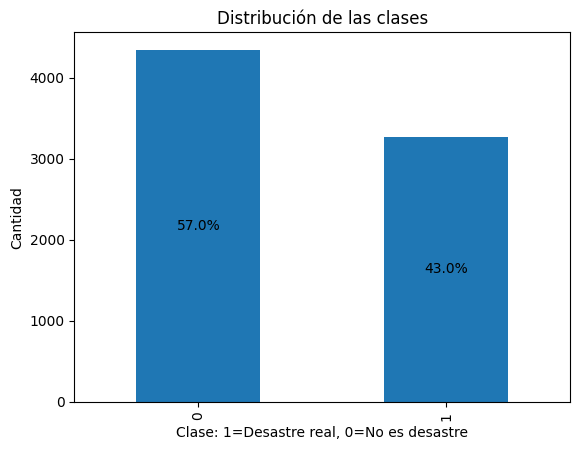

In [ ]:
# Grafico de las clases

ax = df['target'].value_counts().plot(kind='bar')
plt.title('Distribución de las clases')
plt.xlabel('Clase: 1=Desastre real, 0=No es desastre')
plt.ylabel('Cantidad')

# Obtener los valores de las barras
totals = []
for i in ax.patches:
    totals.append(i.get_height())

# Configurar el formato del texto del porcentaje
total = sum(totals)
for i in ax.patches:
    # Obtener la altura de la barra
    height = i.get_height()
    # Calcular el porcentaje
    percentage = '{:.1f}%'.format(100 * height / total)
    # Agregar el texto al centro de la barra
    ax.text(i.get_x() + i.get_width() / 2., height / 2., percentage, ha='center', va='center', rotation=0)

plt.show()

### 3. Obtener la lista de stopwords para inglés.


In [4]:
nltk.download('stopwords')
swords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 4. Calcular y mostrar la distribución de palabras para cada una de las clases. Antes de contar debe eliminar las palabras no útiles (stopwords)

In [5]:
for columna in features:
  # Elimina valores Nulos
  df[columna] = df[columna].apply(lambda x: x.replace('N/A', ''))

  # Convierte palabras a minúscula
  df[columna] = df[columna].apply(lambda x: x.lower())

  # Elimina links
  df[columna] = df[columna].apply(lambda x: re.sub(r'http\S+', '', x))

  # Limpia todo excepto caracteres alfanuméricos
  df[columna] = df[columna].apply(lambda x: re.sub("[^a-zA-Z0-9]"," ",x))

  # Elimina stopwords
  df[columna] = df[columna].apply(lambda x: ' '.join([word for word in x.split() if word not in swords]))
df.sample(20)

,id,keyword,location,text,target
4356,6188,hijacker,san francisco bay area,gov brown allows parole 1976 chowchilla school...,0
3413,4884,explode,bloomington,two cans explode wanted drink rest kaldi coffe...,0
4586,6520,injuries,corpus las vegas houston,injuries starting please dallascowboys stay he...,0
4433,6306,hostage,,shadow holdin hostage days,0
4300,6106,hellfire,right next compton,ian hellfire got mistake boss got worse cause ...,0
5865,8378,ruin,boston,lol real issue way nfl trying ruin guy legacy,0
1575,2275,cliff fall,,fall cliff please,1
3355,4802,evacuated,,good thing actually legit fire mall nobody eva...,1
3144,4518,emergency,wildomar ca,child needs emergency care seen emergency depa...,0
3046,4373,earthquake,hawaii usa,usgs reports m1 94 earthquake 5km volcano hawa...,1


## **Pre-procesamiento** (5 puntos)


### 5. Separar la colección en un conjunto de entrenamiento y uno de prueba. Dar un 80% de los registros al conjunto de entrenamiento.


In [6]:
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:\t", X_train.shape)
print("Tamaño del conjunto de prueba:\t\t", X_test.shape)
print("Tamaño del conjunto de etiquetas de entrenamiento:\t", y_train.shape)
print("Tamaño del conjunto de etiquetas de prueba:\t\t", y_test.shape)


Tamaño del conjunto de entrenamiento:	 (6090, 3)
Tamaño del conjunto de prueba:		 (1523, 3)
Tamaño del conjunto de etiquetas de entrenamiento:	 (6090,)
Tamaño del conjunto de etiquetas de prueba:		 (1523,)


### 6. Convertir el conjunto de entrenamiento y el conjunto de pruebas a la representación requerida por el modelo SVM.

In [7]:
# Combina las columnas de texto en una sola columna
X_train['combined_text'] = X_train['keyword'] + ' ' + X_train['location'] + ' ' + X_train['text']
X_test['combined_text'] = X_test['keyword'] + ' ' + X_test['location'] + ' ' + X_test['text']

In [8]:
"""Se debe convertir cada columna textual a una representacion numérica (vectorizacion) para poder entrenar un
clasificador SVM.

En el jupyter de la clase 5 usan Bag of Words, tambien se podria usar TF-IDF o Word2Vec para realizar esta conversión.
"""

# Vectorizacion con Bag of Words
vectorizer = CountVectorizer(max_features=50000)

X_train_bow = vectorizer.fit_transform(X_train['combined_text']).toarray()
X_test_bow = vectorizer.transform(X_test['combined_text']).toarray()

print(X_train_bow.shape)
print(X_test_bow.shape)
print(vectorizer.get_feature_names_out())


(6090, 16230)
(1523, 16230)
['00' '000' '0000' ... 'zumiez' 'zwe' 'zzzz']


## **Experimentos** (10 puntos)

### 7. Implementar y entrenar un clasificador usando SVM.

In [ ]:
# Crea un clasificador SVC
svm_classifier = SVC(kernel='linear')

# Registra el tiempo de inicio
start_time = time.time()

# Entrena el clasificador
svm_classifier.fit(X_train_bow, y_train)

# Registra el tiempo de finalización
end_time = time.time()

# Calcula la duración del entrenamiento
training_time = end_time - start_time

print(f"El entrenamiento tomó {training_time:.2f} segundos.")


El entrenamiento tomó 171.95 segundos.



### 8. Obtener predicciones del modelo SVM usando el conjunto de prueba.

In [ ]:
# Registra el tiempo de inicio
start_time = time.time()
y_pred = svm_classifier.predict(X_test_bow)
# Registra el tiempo de finalización
end_time = time.time()
# Calcula la duración del entrenamiento
inference_time = end_time - start_time
print(f"La inferencia tomó {inference_time:.2f} segundos.")
print(y_pred)

La inferencia tomó 23.23 segundos.
[0 0 0 ... 1 1 1]


## **Evaluación** (5 puntos)


### 9. Obtener los valores de precisión, recall, f1-score y acierto para el modelo. Tanto globales como por clase.

In [ ]:
# Precisión, recall, f1-score y acierto globales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Métricas globales:")
print("Precisión:\t", accuracy)
print("Recall:\t\t", recall)
print("F1-score:\t", f1)
print("Acierto:\t", accuracy)


# Precisión, recall, f1-score y acierto por clase
print("\nMétricas por clase:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(cm)


Métricas globales:
Precisión:	 0.7511490479317138
Recall:		 0.6810477657935285
F1-score:	 0.6999208234362629
Acierto:	 0.7511490479317138

Métricas por clase:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       874
           1       0.72      0.68      0.70       649

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523


Matriz de confusión:
[[702 172]
 [207 442]]


### 10. Comentar los resultados obtenidos.


**Evaluación del modelo SVM con BoW**

El modelo SVM obtuvo una precisión relativamente alta ($>.77$), lo que indica que clasifica correctamente una gran  parte de los tweets, sin embargo, el modelo tiene un recall moderado ($~.68$), con una tendencia a clasificar mejor los resultados donde no hubo desastre (clase 0).

El balance entre precisión y recall es moderado (f1-score $= .70$), mostrando un rendimiento aceptable.

La matriz de confusión muestra que el modelo tiene una mayor facilidad para identificar los tweets que no son desastres (clase 0).

Sin embargo, se puede mejorar en identificar correctamente los tweets que son desastres (clase 1). Una mejora podría ser probar con otras técnicas de vectorización, como TF-IDF o Word2Vec.


# **B) Long Short-Term Memory (LSTM)**



## **Pre-procesamiento** (5 puntos)


### 11. Utilice las mismas particiones de entrenamiento y pruebas obtenidas en el ejercicio A)


### 12. Convertir el conjunto de entrenamiento y el conjunto de pruebas a la representación requerida por el modelo LSTM.

In [9]:
import string
from nltk.tokenize import word_tokenize
# Cargar el tokenizer de NLTK
nltk.download('punkt')

def tokenize(text):
    # Eliminar caracteres no ASCII
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # Crear un regex para eliminar puntuación, números y saltos de línea/tabulación
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')

    # Eliminar puntuación y números, y convertir el texto a minúsculas
    nopunct = regex.sub(" ", text.lower())

    # Tokenizar usando NLTK
    return word_tokenize(nopunct)

# Diccionario
def process_word_to_ix(sentences_df, df_column):
    """
    Creates a dictionary of words from sentences in a DataFrame.
    Parameters:
      sentences_df: DataFrame Table with the column of texts to be processed.
      df_column: Column name.
    Returns:
      word_to_ix: a dictionary of words
    """
    word_to_ix = {"":0, "UNK":1}
    for sentence in sentences_df[df_column]:
      for word in tokenize(sentence):
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    return(word_to_ix)

vocab2index = process_word_to_ix(X_train, 'combined_text')
print(f'Tamaño del diccionario: {len(vocab2index)}\n{vocab2index}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Tamaño del diccionario: 15509
{'': 0, 'UNK': 1, 'military': 2, 'texas': 3, 'courageous': 4, 'honest': 5, 'analysis': 6, 'need': 7, 'use': 8, 'atomic': 9, 'bomb': 10, 'hiroshima': 11, 'japanese': 12, 'refused': 13, 'surrender': 14, 'engulfed': 15, 'zachzaidman': 16, 'thescore': 17, 'wld': 18, 'b': 19, 'shame': 20, 'golf': 21, 'cart': 22, 'became': 23, 'flames': 24, 'boycottbears': 25, 'massacre': 26, 'cottonwood': 27, 'arizona': 28, 'tell': 29, 'barackobama': 30, 'rescind': 31, 'medals': 32, 'honor': 33, 'given': 34, 'us': 35, 'soldiers': 36, 'wounded': 37, 'knee': 38, 'sign': 39, 'amp': 40, 'rt': 41, 'drought': 42, 'spokane': 43, 'wa': 44, 'worried': 45, 'ca': 46, 'might': 47, 'affect': 48, 'extreme': 49, 'weather': 50, 'dampen': 51, 'economy': 52, 'lava': 53, 'medan': 54, 'indonesia': 55, 'youngheroesid': 56, 'blast': 57, 'power': 58, 'red': 59, 'pantherattack': 60, 'jamilazzaini': 61, 'alifaditha': 62, 'wreckage': 63, 'conclusively': 64, 'confirmed': 65, 'mh': 66, 'malaysia': 67, 'pm

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 1. Tokenización:
# Crear un tokenizador que considere palabras más frecuentes
tokenizer = Tokenizer(num_words=len(vocab2index))
# Ajustar el tokenizador a los datos de entrenamiento para crear un vocabulario
tokenizer.fit_on_texts(X_train['combined_text'])

# Convertir el texto en secuencias de enteros, donde cada entero representa una palabra en el vocabulario
X_train_sequences = tokenizer.texts_to_sequences(X_train['combined_text'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['combined_text'])

# Determine cual es la secuencia mas larga para determinar el tamaño del embedding
max_train = 0
for sequence in X_train_sequences:
  max_train = max(max_train, len(sequence))
print("max_train ", max_train)

max_test = 0
for sequence in X_test_sequences:
  max_test = max(max_test, len(sequence))
print("max_test ", max_test)

# 2. Padding:
# Establecer la longitud máxima de la secuencia (ajustar según sea necesario)
max_length = max(max_test, max_train)
print("max_length ", max_length)

# Asegurar que todas las secuencias tengan la misma longitud rellenando con ceros las secuencias más cortas
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

# 3. Conversión a tensores de PyTorch:
# Convertir las secuencias rellenadas y las etiquetas en tensores de PyTorch
X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)


max_train  29
max_test  27
max_length  29
torch.Size([6090, 29])
torch.Size([1523, 29])
torch.Size([6090])
torch.Size([1523])


## **Experimentos** (10 puntos)

### 13. Utilice la biblioteca Pytorch para implementar y entrenar un clasificador usando una red recurrente LSTM.

### 14. Durante el entrenamiento grafique la curva de error, explique los resultados obtenidos en gráfica y ajuste el modelo o el proceso de entrenamiento apropiadamente (por ejemplo, verifique que el modelo no esté sobre-ajustado)

### 15. Obtener predicciones del modelo LSTM usando el conjunto de prueba.




## **Evaluación** (5 puntos)


In [11]:
# Definición del modelo LSTMClassifier
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate=0.01):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1)  # Capa lineal para salida binaria
        self.sigmoid = nn.Sigmoid()  # Función de activación sigmoide

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = hidden[-1]
        hidden = self.dropout(hidden)
        tag_space = self.fc(hidden)
        pred = self.sigmoid(tag_space)  # Salida 0 o 1
        # print("prediccion ", pred, pred.round())
        return pred


In [19]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hiperparámetros
vocab_size = len(vocab2index)   # Tamaño del vocabulario
embedding_dim = max_length     # Dimensionalidad de los embeddings
hidden_dim = 8        # Dimensionalidad de las capas ocultas de la LSTM
output_dim = 1        # Salida binaria (clasificación binaria)
lr = 0.1              # Tasa de aprendizaje
epochs = 50           # Número de épocas
batch_size = 32       # Tamaño de lote

# Crear el modelo, la función de pérdida y el optimizador
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim).to(device)

# criterion = nn.HingeEmbeddingLoss()
criterion = nn.BCEWithLogitsLoss()

# optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
# optimizer = optim.RMSprop(model.parameters(), lr=lr)

# Crear DataLoader para manejar los lotes de datos
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Función para entrenar el modelo
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()  # Modo de entrenamiento
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            # Paso 1. Pytorch acumula gradientes, por eso se resetean
            # model.zero_grad()  # Resetear gradientes
            optimizer.zero_grad()  # Resetear gradientes

            # Paso 2. Genera una prediccion
            predictions = model(texts).squeeze(1)  # Forward pass
            # print(predictions)
            # Paso 3. Calcula la perdida, y actualiza gradientes

            # Convert labels to float
            labels = labels.float()

            loss = criterion(predictions, labels)  # Cálculo de la pérdida

            # print(texts)
            # print('preds', predictions)
            # print('labels ', labels)
            # print('loss ', loss)

            loss.backward()  # Backpropagation
            optimizer.step()  # Actualizar pesos

            epoch_loss += loss.item()

        train_losses.append(epoch_loss/len(train_loader)) # Agregar la pérdida promedio de la época
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.8f}')

    return train_losses


# Registra el tiempo de inicio
start_time = time.time()

# Entrena el clasificador
train_losses = train_model(model, train_loader, criterion, optimizer, epochs)

# Registra el tiempo de finalización
end_time = time.time()

# Calcula la duración del entrenamiento
training_time = end_time - start_time

print(f"El entrenamiento tomó {training_time:.2f} segundos.")

Epoch 1/50, Loss: 0.69415047
Epoch 2/50, Loss: 0.69318927
Epoch 3/50, Loss: 0.69316096
Epoch 4/50, Loss: 0.69315636
Epoch 5/50, Loss: 0.69315585
Epoch 6/50, Loss: 0.69315366
Epoch 7/50, Loss: 0.69314957
Epoch 8/50, Loss: 0.69315079
Epoch 9/50, Loss: 0.69315035
Epoch 10/50, Loss: 0.69314921
Epoch 11/50, Loss: 0.69314921
Epoch 12/50, Loss: 0.69314829
Epoch 13/50, Loss: 0.69314877
Epoch 14/50, Loss: 0.69314891
Epoch 15/50, Loss: 0.69314806
Epoch 16/50, Loss: 0.69314798
Epoch 17/50, Loss: 0.69314801
Epoch 18/50, Loss: 0.69314752
Epoch 19/50, Loss: 0.69314755
Epoch 20/50, Loss: 0.69314809
Epoch 21/50, Loss: 0.69314744
Epoch 22/50, Loss: 0.69314711
Epoch 23/50, Loss: 0.69314855
Epoch 24/50, Loss: 0.69314728
Epoch 25/50, Loss: 0.69314772
Epoch 26/50, Loss: 0.69314750
Epoch 27/50, Loss: 0.69314744
Epoch 28/50, Loss: 0.69314721
Epoch 29/50, Loss: 0.69314740
Epoch 30/50, Loss: 0.69314735
Epoch 31/50, Loss: 0.69314722
Epoch 32/50, Loss: 0.69314741
Epoch 33/50, Loss: 0.69314742
Epoch 34/50, Loss: 

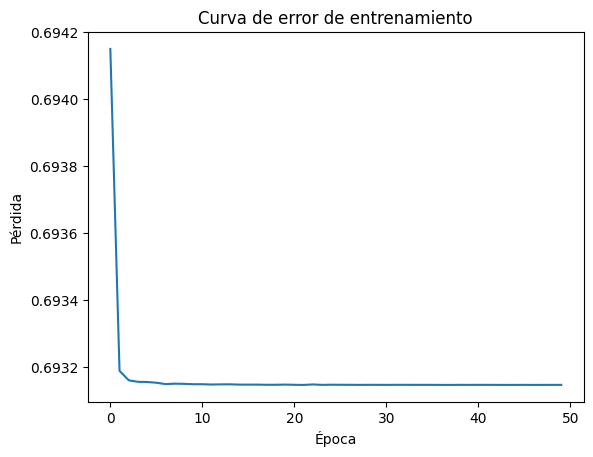

Accuracy: 43.05%


In [20]:
plt.plot(train_losses)
plt.title('Curva de error de entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# Función de evaluación (utilizando los mismos datos de entrenamiento para simplificar)
def evaluate_model(model, X, y):
    model.eval()  # Modo de evaluación
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        predictions = torch.sigmoid(model(X).squeeze(1))
        predictions = torch.round(predictions)
        accuracy = (predictions == y).float().mean().item()  # Calcular precisión
    return accuracy

# Evaluar la precisión en el conjunto de entrenamiento
accuracy = evaluate_model(model, X_train_tensor, y_train_tensor)
print(f'Accuracy: {accuracy * 100:.2f}%')

### 16. Obtener los valores de precisión, recall, f1-score y acierto para el modelo. Tanto globales como por clase.


In [21]:
# Función de evaluación que devuelve la matriz de confusión y las métricas
def evaluate_model_with_confusion_matrix(model, X, y):
    model.eval()  # Modo de evaluación
    with torch.no_grad():
        X, y = X.to(device), y.to(device)
        predictions = torch.sigmoid(model(X).squeeze(1))
        predictions_rounded = torch.round(predictions)  # Convertir probabilidades a 0 o 1

        y_true = y.cpu().numpy()  # Etiquetas reales
        y_pred = predictions_rounded.cpu().numpy()  # Predicciones redondeadas

        # Calcular matriz de confusión
        cm = confusion_matrix(y_true, y_pred)

        # Calcular métricas
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="binary")
        recall = recall_score(y_true, y_pred, average="binary")
        f1 = f1_score(y_true, y_pred, average="binary")
        print(classification_report(y_true, y_pred))
        return cm, accuracy, precision, recall, f1

# Evaluar las métricas en el conjunto de entrenamiento
cm, accuracy, precision, recall, f1 = evaluate_model_with_confusion_matrix(model, X_train_tensor, y_train_tensor)

# Imprimir las métricas
print(f"Global Accuracy: {accuracy * 100:.2f}%")
print(f"Global Precision: {precision * 100:.2f}%")
print(f"Global Recall: {recall * 100:.2f}%")
print(f"Global F1-Score: {f1 * 100:.2f}%")
print(cm)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3468
           1       0.43      1.00      0.60      2622

    accuracy                           0.43      6090
   macro avg       0.22      0.50      0.30      6090
weighted avg       0.19      0.43      0.26      6090

Global Accuracy: 43.05%
Global Precision: 43.05%
Global Recall: 100.00%
Global F1-Score: 60.19%
[[   0 3468]
 [   0 2622]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 17. Comente y compare los resultados obtenidos con SVM y LSTM.

Comparación de resultados SVM vs LSTM
-------------------------------------
SVM:
- Precisión: Alta (>0.77)
- Recall: Moderado (~0.68)
- F1-score: Moderado (~0.70)
- Tendencia a clasificar mejor la clase 0 (no desastre).
- Puede mejorar en identificar la clase 1 (desastre).

LSTM:
- Precisión: Baja
- Recall: Bajo
- F1-score: Bajo
- Tendencia a clasificar todo como clase 0 (no desastre).
- Puede que el modelo no esté aprendiendo adecuadamente las características de los tweets que son desastres.
- Posible sobreajuste del modelo

Posibles razones por las que el LSTM falla en predecir la clase 1:
- **Datos desbalanceados:** El conjunto de datos puede tener más ejemplos de la clase 0 que de la clase 1. Esto puede llevar a que el modelo se sesgue hacia la clase mayoritaria.
- **Complejidad del modelo:** El modelo LSTM puede ser demasiado complejo para la cantidad de datos disponibles.
- **Hiperparámetros:** La configuración de los hiperparámetros del modelo LSTM (como la tasa de aprendizaje, el número de capas, etc.) puede no ser óptima.
- **Datos insuficientes:** La cantidad de datos de entrenamiento puede ser insuficiente para que el modelo aprenda las características de la clase 1.
- **Preprocesamiento:** El preprocesamiento del texto puede no ser adecuado para el modelo LSTM.
- **Características limitadas:** El modelo LSTM puede no estar capturando las características del texto que son relevantes para la clasificación de desastres.
- **Sobreajuste:** El modelo puede estar sobreajustando los datos de entrenamiento, lo que afecta su capacidad de generalizar a los datos de prueba.

Recomendaciones para mejorar el LSTM:
- **Balancear los datos:** Utilizar técnicas de sobremuestreo o submuestreo para balancear las clases.
- **Simplificar el modelo:** Reducir la complejidad del modelo para evitar el sobreajuste.
- **Optimizar los hiperparámetros:** Ajustar la tasa de aprendizaje, el tamaño de lote, el número de épocas, la dimensionalidad de los vectores, etc.
- **Aumentar los datos:** Obtener más datos de entrenamiento.
- **Mejorar el preprocesamiento:** Experimentar con diferentes técnicas de preprocesamiento de texto, como la eliminación de stopwords o el uso de stemming.
- **Capturar características más relevantes:** Considerar el uso de técnicas como Word2Vec o BERT para capturar características más semánticas del texto.
- **Regularización:** Utilizar técnicas de regularización para evitar el sobreajuste.
- **Entrenamiento más largo:** Aumentar el número de épocas de entrenamiento.